In [1]:
# this notebook is used to explore the data we have around diagnosis
# after inferring date of diagnosis, decided that we want to predict CDK death, not CKD diagnosis

In [2]:
# cross check dates of first azotemia, low USG with diagnoses
# come up with scheme for first diagnosed date
# generally look at what diagnosis info we have
# add a column to diagnose based on IRIS reference ranges
# add a column for Rachel's diagnosis reference range for species she calculated

In [3]:
# 'Date of Onset of Azoatemia'  completely empty
# 'Date of USG less than 1,035' empty
# 'Onset of azotaemia' these are dates and there are 56 of them

In [4]:
# SCHEME FOR INFERRING DATE OF DIAGNOSIS
# logic_flag
# 0: can't infer
# 1: date of diagnosis (4 cats)
# 2. 'First report of CKD CS' (7)
# 3. Ante-mortem Dx TRUE and use earliest 'Onset of azotaemia' / 'Date of first low USG'
# 4. Died of CKD  and use earliest 'Onset of azotaemia' / 'Date of first low USG'

# sometimes the first indicator date is the same as date of death.  Once labeling is done will need to compare date of death and fisrt indicator date and consider excluding record if these are too close in time.


In [5]:
import numpy as np
import pandas as pd
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [6]:
# read in unified animal list
file = '../Data/big_cats/Access_DB_table_exports/PrevalenceIncludedFelidsTZ_ZV_WA_SA_MG_DM.xlsx'
data = pd.read_excel(file)

In [7]:
data.columns

Index(['Animal Name', 'ARKS Number', 'Microchip Number',
       'Species (common name)', 'Sex', 'Alternative ARKS Nos',
       'Studbook Number', 'GAN ID', 'Status (alive/deceased/transacted)',
       'Zoo Location', 'Date  of Birth', 'Date of Transaction',
       'Date of Death', 'Age in years at death', 'Date of Onset of Azoatemia',
       'Date of USG less than 1,035', 'Ante-mortem Dx of CKD',
       'Date of first low USG', 'Onset of azotaemia', 'Date of diagnosis',
       'Comments re kidney function', 'First report of CKD CS', 'Age at Death',
       'Cause of Death', 'Acute kidney failure', 'CKD - cause of mortality',
       'CKD - co-morbidity', 'Pyometra (survived)', 'Pyometra cause of death',
       'Unknown', 'Neonatal', 'Neurological', 'Endocrine', 'Neoplasia',
       'Old Age debility', 'Trauma', 'Infection', 'GIT',
       'Respiratory/Cardiovascular', 'Pathology Report Numbers',
       'Post Mortem Report Number', 'International transaction',
       'Dam ARKS Number', 'Sir

In [10]:
# SCHEME FOR INFERRING DATE OF DIAGNOSIS
# logic_flag
# 0: can't infer
# 1: date of diagnosis (4 cats)
# 2. 'First report of CKD CS' (7)
# 3. Ante-mortem Dx TRUE and use earliest 'Onset of azotaemia' / 'Date of first low USG'
# 4. Died of CKD  and use earliest 'Onset of azotaemia' / 'Date of first low USG'

In [11]:
data['inferred_diagnosis_date'] = None
data['logic_flag'] = 0

logic_flag_4 =(data['CKD - cause of mortality']) & ((data['Onset of azotaemia'].notnull()) | (data['Date of first low USG'].notnull()) )
data.loc[logic_flag_4, 'logic_flag'] = 4
data.loc[logic_flag_4, 'inferred_diagnosis_date'] = data[logic_flag_4][['Onset of azotaemia', 'Date of first low USG']].min(axis=1)

logic_flag_3 =(data['Ante-mortem Dx of CKD']) & ((data['Onset of azotaemia'].notnull()) | (data['Date of first low USG'].notnull()) )
data.loc[logic_flag_3, 'logic_flag'] = 3
data.loc[logic_flag_3, 'inferred_diagnosis_date'] = data[logic_flag_3][['Onset of azotaemia', 'Date of first low USG']].min(axis=1)

logic_flag_2 = data['First report of CKD CS'].notnull()
data.loc[logic_flag_2, 'logic_flag'] = 2
data.loc[logic_flag_2, 'inferred_diagnosis_date'] = data[logic_flag_2]['First report of CKD CS']

logic_flag_1 = data['Date of diagnosis'].notnull()
data.loc[logic_flag_1, 'logic_flag'] = 1
data.loc[logic_flag_1, 'inferred_diagnosis_date'] = data[logic_flag_1]['Date of diagnosis']

data['inferred_diagnosis_date'] = pd.to_datetime(data['inferred_diagnosis_date'])

data['earliest_indicator'] = data[['Onset of azotaemia', 'Date of first low USG', 'inferred_diagnosis_date']].min(axis=1)
data['time_between_diagnosis_and_death'] = data['Date of Death'] - data['inferred_diagnosis_date']
data['time_between_earliest_indicator_and_death'] = data['Date of Death'] - data['earliest_indicator']


In [12]:
data.head()

,Animal Name,ARKS Number,Microchip Number,Species (common name),Sex,Alternative ARKS Nos,Studbook Number,GAN ID,Status (alive/deceased/transacted),Zoo Location,Date of Birth,Date of Transaction,Date of Death,Age in years at death,Date of Onset of Azoatemia,"Date of USG less than 1,035",Ante-mortem Dx of CKD,Date of first low USG,Onset of azotaemia,Date of diagnosis,Comments re kidney function,First report of CKD CS,Age at Death,Cause of Death,Acute kidney failure,CKD - cause of mortality,CKD - co-morbidity,Pyometra (survived),Pyometra cause of death,Unknown,Neonatal,Neurological,Endocrine,Neoplasia,Old Age debility,Trauma,Infection,GIT,Respiratory/Cardiovascular,Pathology Report Numbers,Post Mortem Report Number,International transaction,Dam ARKS Number,Sire ARKS Number,Sibling ARKS Number,Transacted internationally,Hand-raised,Housing (confined enclosure/open range),Excluded from study?,Comments:,Biochem data,Urine data,inferred_diagnosis_date,logic_flag,earliest_indicator,time_between_diagnosis_and_death,time_between_earliest_indicator_and_death
0,Amber,800100,NaN,Lion,female,NaN,NaN,NaN,Dead,Taronga Zoo,1980-12-08,NaT,1982-04-24,1.375342,NaN,NaN,False,NaT,NaT,NaT,NaN,NaN,1y4m16d,euthanasia- renal failure,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,False,False,NaN,True,No biochem data. No clinical history. No PM re...,False,True,NaT,0,NaT,NaT,NaT
1,Askari,A49221,00-0643-10BA,Cheetah,male,NaN,6132,MIG12-029516691,Dead,Monarto Zoo,2004-09-11,NaT,2013-04-04,8.567123,NaN,NaN,False,2013-04-04,2013-03-03,NaT,NaN,NaN,8y6m22d,CKD and corneal ulcer,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,False,False,NaN,False,NaN,True,True,2013-03-03,4,2013-03-03,32 days,32 days
2,Audrey,890000,7F-7F4A-2238,Asiatic Lion,female,NaN,88,MIG12-25946946,Dead,Western Plains Zoo,1980-02-27,NaT,2001-07-03,21.361644,NaN,NaN,True,1998-05-28,2001-03-01,2001-03-01,NaN,NaN,NaN,CKD,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,True,False,NaN,False,"Born LincolnPark Zoo, Chicago",True,True,2001-03-01,1,1998-05-28,124 days,1132 days
3,Bengal,K46,NaN,Bengal Tiger,male,NaN,NaN,NaN,Dead,Taronga Zoo,NaT,NaT,1973-05-23,NaN,NaN,NaN,True,NaT,NaT,1973-01-23,history of vomiting and anorexia,NaN,old,CKD,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,False,False,NaN,False,"PM report, but no USG or biochem",False,False,1973-01-23,1,1973-01-23,120 days,120 days
4,Blackfoot,K0095,NaN,Leopard,female,NaN,NaN,NaN,Dead,Taronga Zoo,1967-01-01,NaT,1986-12-24,19.991781,NaN,NaN,False,NaT,NaT,NaT,NaN,NaN,NaN,"kidney stones, haematuria, old age",False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,False,NaN,NaN,NaN,False,False,NaN,False,NaN,False,True,NaT,0,NaT,NaT,NaT


In [13]:
data['CKD - cause of mortality'].value_counts()

False    348
True      76
Name: CKD - cause of mortality, dtype: int64

In [29]:
# cats that we couldn't infer diagnosis date for
CKD = data[(data['CKD - cause of mortality']==True) & (data['logic_flag']!=0)]
len(CKD)

40

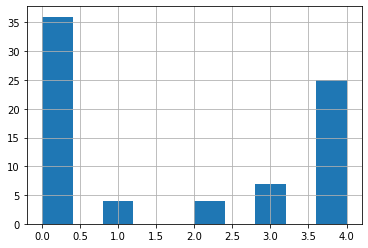

In [37]:
CKD_cats = data[data['CKD - cause of mortality']==True]
CKD_cats['logic_flag'].hist()

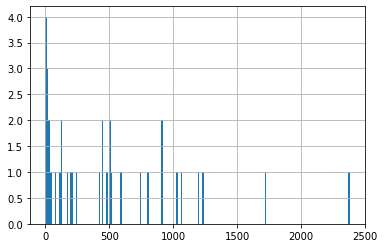

In [52]:
# let's look at cats with CKD that we have an inferred diagnosis date for
data_date_inferred = CKD_cats[CKD_cats['logic_flag'] != 0]
data_date_inferred['time_between_diagnosis_and_death'].dt.days.hist(bins = 200)

In [16]:
CKD.loc[67] # cats still alive: 27, 42, 52, 65

Animal Name                                             Tigerboy
ARKS Number                                               A10134
Microchip Number                                    00-01C9-2BFF
Species (common name)                             Sumatran Tiger
Sex                                                         male
Alternative ARKS Nos                                         NaN
Studbook Number                                              NaN
GAN ID                                               GAN 5723890
Status (alive/deceased/transacted)                          Dead
Zoo Location                                        Adelaide Zoo
Date  of Birth                               1990-04-29 00:00:00
Date of Transaction                                          NaT
Date of Death                                2008-05-27 00:00:00
Age in years at death                                    18.0904
Date of Onset of Azoatemia                                   NaN
Date of USG less than 1,0

In [17]:
CKD['Date of Death'] - CKD['inferred_diagnosis_date']

1      32 days
2     124 days
3     120 days
7    1067 days
8     447 days
10    519 days
14   1034 days
18    169 days
20    906 days
21      0 days
22    427 days
23    195 days
27         NaT
29   1193 days
30   1233 days
34     82 days
35     21 days
36    205 days
37      4 days
38    117 days
39    587 days
41    739 days
42         NaT
43    484 days
51    442 days
52         NaT
55     47 days
59    245 days
60     21 days
62    801 days
63   2381 days
64     15 days
65         NaT
67      5 days
68     28 days
69    510 days
70    910 days
71     10 days
72    504 days
74   1721 days
dtype: timedelta64[ns]

In [18]:
CKD[['time_between_diagnosis_and_death', 'time_between_earliest_indicator_and_death']]

,time_between_diagnosis_and_death,time_between_earliest_indicator_and_death
1,32 days,32 days
2,124 days,1132 days
3,120 days,120 days
7,1067 days,1067 days
8,447 days,447 days
10,519 days,519 days
14,1034 days,1034 days
18,169 days,169 days
20,906 days,906 days
21,0 days,0 days


In [19]:
data.dtypes

Animal Name                                           object
ARKS Number                                           object
Microchip Number                                      object
Species (common name)                                 object
Sex                                                   object
Alternative ARKS Nos                                  object
Studbook Number                                       object
GAN ID                                                object
Status (alive/deceased/transacted)                    object
Zoo Location                                          object
Date  of Birth                                datetime64[ns]
Date of Transaction                           datetime64[ns]
Date of Death                                 datetime64[ns]
Age in years at death                                float64
Date of Onset of Azoatemia                           float64
Date of USG less than 1,035                          float64
Ante-mortem Dx of CKD   

In [20]:
len(data['ARKS Number'].unique())

424

In [21]:
data['Ante-mortem Dx of CKD'].value_counts()

False    410
True      14
Name: Ante-mortem Dx of CKD, dtype: int64

In [22]:
len(data[(data['CKD - cause of mortality'] == True) & (data['Ante-mortem Dx of CKD'] == True)])

11

In [23]:
data['Date of diagnosis'].value_counts()

2011-11-16    1
2013-03-07    1
2001-03-01    1
1973-01-23    1
Name: Date of diagnosis, dtype: int64

In [24]:
data['First report of CKD CS'].value_counts()

28-jul-10    2
16-may-99    1
20-3-92      1
22-may-08    1
25-10-02     1
21-Oct-94    1
Name: First report of CKD CS, dtype: int64

In [25]:
data['Onset of azotaemia'].value_counts().sum()

56

In [26]:
data['Date of first low USG'].value_counts().sum()

39

In [27]:
data['Date of USG less than 1,035'].value_counts()

Series([], Name: Date of USG less than 1,035, dtype: int64)

In [28]:
data['Date of Onset of Azoatemia'].value_counts()

Series([], Name: Date of Onset of Azoatemia, dtype: int64)